In [1]:
import sys;
sys.path.insert(0, '..')

## Chapter 9 Code Snippets and Listings

### Estimating the frequency of a periodic quantum state (9.1)

Listing 9.1 Function to create a circuit that encodes a frequency value `v` in a quantum state with `n` qubits

In [2]:
from sim_circuit import QuantumRegister, QuantumCircuit
from math import pi

def encode_frequency(n, v):
    q = QuantumRegister(n)
    qc = QuantumCircuit(q)

    for j in range(n):
        qc.h(q[j])

    for j in range(n):
        qc.p(2 * pi / 2 ** (n - j) * v, q[j])

    qc.report('geometric_sequence') # This report will show us the geometric sequence state

    qc.iqft(range(n))

    qc.report('iqft')

    return qc

Listing 9.2 Generate a phased discrete sinc state with `n` qubits and a frequency value `v`

In [3]:
from util import cis, prod

def complex_sincd(n, v):
    N = 2 ** n
    return [prod(
        cos((v - k) * pi / 2 ** (j + 1)) * cis((v - k) * pi / 2 ** (j + 1))
        for j in range(n)) for k in range(2 ** n)]

Let's consider two examples. We will create two circuits with $n = 3$ qubits, and frequencies $v = 3$ and $v = 3.8$, using the function calls below:

In [4]:
n = 3

qc1 = encode_frequency(n, 3)

qc2 = encode_frequency(n, 3.8)

Let's simulate 10 runs of this circuit:

In [5]:
result = qc1.measure(shots = 10)

In [6]:
result['counts']

{3: 10}

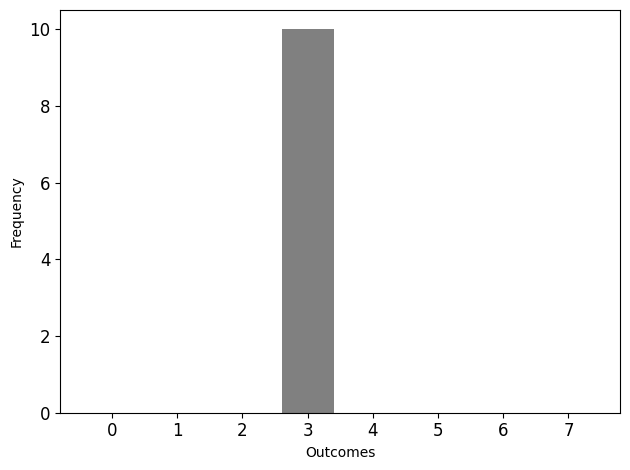

In [7]:
from util import plot_bars

for outcome in range(2**n):
    result['counts'][outcome] = result['counts'].get(outcome, 0)
    
plot_bars(dict(sorted(result['counts'].items())), '', 'Outcomes', 'Frequency', color='grey')

Next, let's simulate 10 runs of the second example circuit (`v = 3.8`):

In [8]:
result = qc2.measure(shots = 10)

In [9]:
result['counts']

{4: 8, 6: 1, 3: 1}

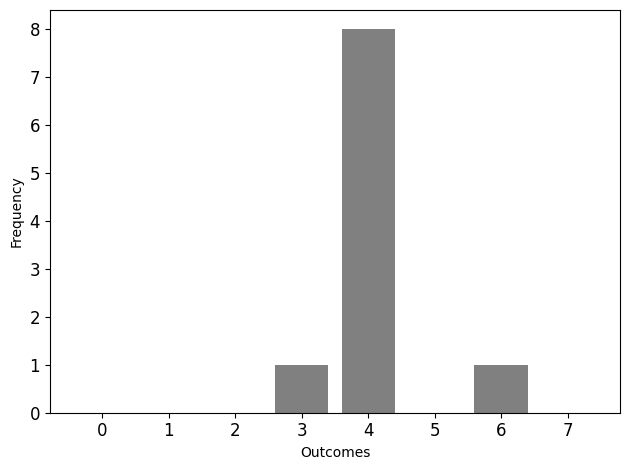

In [10]:
for outcome in range(2**n):
    result['counts'][outcome] = result['counts'].get(outcome, 0)
    
plot_bars(dict(sorted(result['counts'].items())), '', 'Outcomes', 'Frequency', color='grey')

### Getting better angle estimates with more qubits (section 9.1.1)

First, let's create a circuit with $n = 3$ and $v_3 = 4.76$:

In [11]:
n = 3
v = 4.76
qc = encode_frequency(n, v)

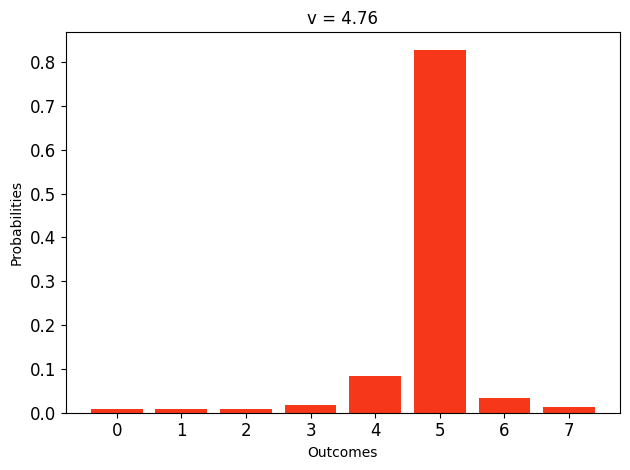

In [12]:
from util import list_to_dict

state = qc.run()
probs = [abs(a)**2 for a in state]
plot_bars(list_to_dict(probs, False), f'v = {v}', 'Outcomes', 'Probabilities')

In [13]:
result = qc.measure(shots = 100)

result['counts']

{5: 78, 4: 13, 7: 1, 6: 5, 0: 2, 3: 1}

Let's simulate 100 shots of this circuit:

In [14]:
n = 5
v = 19.05
qc = encode_frequency(n, v)

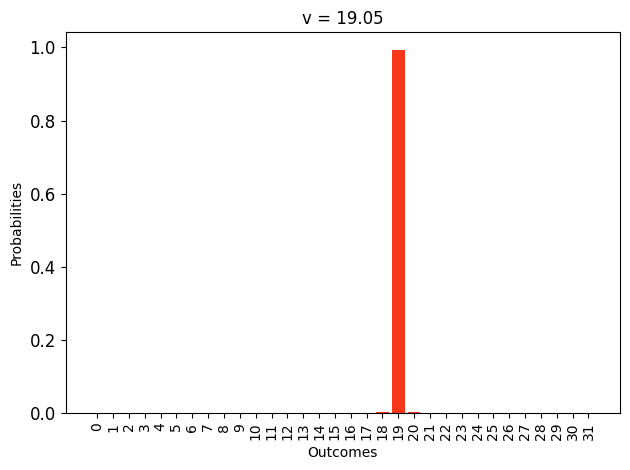

In [15]:
state = qc.run()
probs = [abs(a)**2 for a in state]
plot_bars(list_to_dict(probs, False), f'v = {v}', 'Outcomes', 'Probabilities')

Let's simulate 100 runs of this circuit:

In [16]:
result = qc.measure(shots = 100)

result['counts']

{19: 99, 20: 1}

### Reading between the ticks: getting better estimates with interpolation (section 9.1.2)

We can approximate the decimal part of the encoded frequency by

$$\frac{\sqrt{p_a}}{\sqrt{p_a} + \sqrt{p_b}}$$

where $p_a$ and $p_b$ are the probabilities of the outcomes that fall above and below the true value $v$ of a frequency that is not an integer.

Let's apply this method by revisiting the circuit for $n = 3$ and $v_3 = 4.76$, where the simulated measurement results were:

In [17]:
result['counts'] = {5: 79, 4: 12, 6: 3, 7: 3, 3: 2, 2: 1}

In the pseudo-random samples, the two most frequent outcomes were 4 and 5. So, we estimate the integer part of the encoded value with 4. We can compute our estimate of the decimal part of the encoded value with the following Python code:

In [18]:
from math import sqrt

p_4 = result['counts'][4]/sum(result['counts'].values()) # <1>
p_5 = result['counts'][5]/sum(result['counts'].values())

decimal_estimate = sqrt(p_5)/(sqrt(p_4)+ sqrt(p_5))

In [19]:
decimal_estimate

0.7195580800495327

### Quantum circuits as rotations with eigenstates and eigenvalues (section 9.2)

Let's start with single qubit circuit created by the function below which consists of one $R_Y$-gate with an angle parameter of $2\theta$:

In [20]:
def ry_circuit(theta):
    q = QuantumRegister(1)
    qc = QuantumCircuit(q)
    qc.ry(theta, q[0])

    return qc

The circuit returned by the function `ry_eigen_circuit` below prepares th single-qubit state $[\frac{i}{\sqrt{2}}, \frac{1}{\sqrt{2}}]$:

In [21]:
def ry_eigen_circuit():
    q = QuantumRegister(1)
    qc = QuantumCircuit(q)

    qc.x(q[0])
    qc.rx(-pi/2, q[0])

    return qc

In [22]:
from util import print_state_table

qc = ry_eigen_circuit()
state = qc.run()

print_state_table(state)


Outcome  Binary  Amplitude           Magnitude  Direction  Amplitude Bar             Probability
------------------------------------------------------------------------------------------------
0        0       0.0000 + i0.7071    0.7071       90.00°   ████████████████          0.5   
1        1       0.7071 + i0.0000    0.7071        0.00°   ████████████████          0.5   



We can check that the state prepared by this circuit matches $[\frac{i}{\sqrt{2}}, \frac{1}{\sqrt{2}}]$ using the following code:

In [23]:
from util import all_close

qc = ry_eigen_circuit()
state = qc.run()

assert all_close(state, [1j/sqrt(2), 1/sqrt(2)])

Now, let's apply the $R_Y \left( \frac{\pi}{3} \right)$ gate to the eigenstate:

In [24]:
q = QuantumRegister(1)
qc = QuantumCircuit(q)

qc.x(q[0])
qc.rx(-pi/2, q[0])

theta = pi/6

qc.ry(2*theta, q[0])

state = qc.run()

In [25]:
print_state_table(state)


Outcome  Binary  Amplitude           Magnitude  Direction  Amplitude Bar             Probability
------------------------------------------------------------------------------------------------
0        0      -0.3536 + i0.6124    0.7071      120.00°   ████████████████          0.5   
1        1       0.6124 + i0.3536    0.7071       30.00°   ████████████████          0.5   



We can apply the circuit to the eigenstate multiple times, and the magnitudes of the amplitudes will not change, but the amplitudes will be rotated by the same angle every time:

In [26]:
q = QuantumRegister(1)
qc = QuantumCircuit(q)

qc.x(q[0])
qc.rx(-pi/2, q[0])

theta = pi/6

qc.ry(2*theta, q[0]) # <1>
qc.ry(2*theta, q[0]) # <1>

state = qc.run()

In [27]:
print_state_table(state)


Outcome  Binary  Amplitude           Magnitude  Direction  Amplitude Bar             Probability
------------------------------------------------------------------------------------------------
0        0      -0.6124 + i0.3536    0.7071      150.00°   ████████████████          0.5   
1        1       0.3536 + i0.6124    0.7071       60.00°   ████████████████          0.5   



### The quantum phase estimation algorithm (section 9.3)

First, our "step 0" is to create two registers: one with $m$ qubits that will be used to encode the eigenstate, called the target register, and one with $n$ qubits that we will use to obtain the estimate, called the estimation register. In this example, we only need one qubit for our target register, and we will use $n = 3$ qubits for our estimation register:

In [28]:
n = 3
q = QuantumRegister(n)
a = QuantumRegister(1)
qc = QuantumCircuit(q, a)

Step 1 is to prepare an eigenstate of the circuit $U$ in the target register:

In [29]:
qc.x(a[0])
qc.rx(-pi/2, a[0])

Next, we apply Hadamard gates to each of the qubits in the estimation register. Then, for each qubit $k$]in the estimation register, we apply the circuit $U$ to the target register $2^k$ times, controlled on qubit $k$. To perform this step (step 2) we can write two for-loops:

In [30]:
for i in range(n):
    qc.h(q[i])

theta = 4.7*2*pi/2**n

for i in range(n):
    for _ in range(2**i):
        qc.cry(2*theta, q[i], a[0])  # <1> 

Remember from chapter 3 that the inverse of an $R_X(\theta)$ rotation is $R_X(-\theta)$, and that the X-gate is its' own inverse. We can apply the inverse of the circuit which prepared the eigenstate with the following code:

In [31]:
qc.rx(pi/2, a[0])
qc.x(a[0])

Finally, we apply an IQFT to the estimation register with the following code:

In [32]:
qc.append_iqft(q)

In [33]:
state = qc.run()
print_state_table(state)


Outcome  Binary  Amplitude           Magnitude  Direction  Amplitude Bar             Probability
------------------------------------------------------------------------------------------------
0        0000    0.0986 + i0.0364    0.1051       20.26°   ██                        0.011 
1        0001    0.0748 + i0.0691    0.1018       42.73°   ██                        0.0104
2        0010    0.0485 + i0.1053    0.1159       65.27°   ██                        0.0134
3        0011    0.0064 + i0.1632    0.1633       87.75°   ███                       0.0267
4        0100   -0.1289 + i0.3495    0.3726      110.24°   ████████                  0.1388
5        0101    0.5840 - i0.6318    0.8604      -47.75°   ████████████████████      0.7403
6        0110    0.1880 - i0.0866    0.207       -24.27°   ████                      0.0428
7        0111    0.1287 - i0.0051    0.1288       -2.73°   ███                       0.0166
8        1000    0.0000 + i0.0000    0.0                             

We can check that the estimation register is the phased discrete sinc state we expect with the following Python code:

In [34]:
from util import all_close
from math import cos

n = 3
theta = 4.7*2*pi/2**n
s = complex_sincd(n, theta/(2*pi)*2**n)
assert all_close(state[:2**n], s)

### Circuit-level implementation of the quantum phase estimation algorithm (section 9.4)

Listing 9.3 Function for creating the phase estimation circuit

In [35]:
def phase_estimation_circuit(n, circuit, eigen_circuit=None):
    q = QuantumRegister(n)
    a = QuantumRegister(sum(circuit.regs)) # step 0 (the size of the target register is the same as the number of qubits in the circuit parameter)
    qc = QuantumCircuit(q, a) # target register is last

    if eigen_circuit is not None:
        qc.append(eigen_circuit, a)
        qc.report('eigenstate')

    for i in range(n): # step 1: If a circuit which prepares an eigenstate is passed to the function, then we apply it to the target register
        qc.h(q[i])

    for i in range(n): # step 2
        for _ in range(2**i):
            qc.c_append(circuit, q[i], a)

    qc.report('geometric_sequence_superposition')

    if eigen_circuit is not None: # optional step 3
        qc.append(eigen_circuit.inverse(), a)
        qc.report('geometric_sequence')

    qc.append_iqft(q) #step 4
    qc.report('estimate')

    return qc

Let's create the circuit for the example above:

In [36]:
n = 3
N = 2**n
theta = 4.7*2*pi/N

qc = phase_estimation_circuit(n, ry_circuit(2*theta), ry_eigen_circuit())

We can check that this circuit matches the step-by-step results we got in the previous section using the following code:

In [37]:
eig = qc.reports['eigenstate'][2]
assert all_close(eig, [1j/sqrt(2) if k == 0 else 0 for k in range(N)] +
    [1/sqrt(2) if k == 0 else 0 for k in range(N)])

geom = qc.reports['geometric_sequence'][2]
g = [1/sqrt(N)*cis(k*theta) for k in range(N)]
assert all_close(geom[:N], g)

estimate = qc.reports['estimate'][2]
s = complex_sincd(n, theta/(2*pi)*N)
assert all_close(estimate, s + [0 for _ in range(N)])

### An alternative implementation of phase estimation circuit without qubit swaps (section 9.6)

Listing 9.4 Alternative implementation for creating the phase estimating circuit without qubit swaps in the IQFT

In [38]:
def phase_estimation_circuit(n, circuit, eigen_circuit=None, swap=True):
    q = QuantumRegister(n)
    a = QuantumRegister(sum(circuit.regs))
    qc = QuantumCircuit(q, a) # a is last (at the bottom)

    if eigen_circuit is not None:
        qc.append(eigen_circuit, a)
    qc.report('eigenstate')

    for i in range(n):
        qc.h(q[i])

    for i in range(n):
        for _ in range(2**i):
            if swap:
                qc.c_append(circuit, q[i], a)
            else:
                qc.c_append(circuit, q[n-1-i], a) # reverse the target qubit order
                
    qc.report('geometric_sequence_superposition')

    if eigen_circuit is not None:
        qc.append(eigen_circuit.inverse(), a)

    qc.report('geometric_sequence')

    qc.append_iqft(q, False if swap else True, swap) # apply an IQFT to the estimation register with qubits in reverse order and without swaps
    qc.report('estimate')

    return qc

The following Python code creates a circuit for the same problem as in the previous section using the alternative implementation:

In [39]:
n = 3
N = 2**n
theta = 4.7*2*pi/N
swap = False

qc = phase_estimation_circuit(n, ry_circuit(2*theta), ry_eigen_circuit(), swap)

We can check that the amplitudes of the geometric sequence state match the geometric sequence state created using the first method with the following code:

In [40]:
from util import reverse_index_state

geom = qc.reports['geometric_sequence'][2]
g = [1/sqrt(N)*cis(k*theta) for k in range(N)]
assert all_close(geom[:N], g if swap else reverse_index_state(g)) #The periodic state created has amplitudes in reversed order. We can use the utility function `reverse_index_state` to reorder the amplitudes.

In [41]:
from util_qiskit import show_reports
show_reports(qc)



--------------------------------------------------
4. estimate
--------------------------------------------------
      ┌───┐                                        
q0_0: ┤ H ├─■─────────■────────────────────────────
      └───┘ │P(-π/2)  │        ┌───┐               
q0_1: ──────■─────────┼────────┤ H ├─■─────────────
                      │P(-π/4) └───┘ │P(-π/2) ┌───┐
q0_2: ────────────────■──────────────■────────┤ H ├
                                              └───┘
  q1: ─────────────────────────────────────────────
                                                   

Outcome  Binary  Amplitude           Magnitude  Direction  Amplitude Bar             Probability
------------------------------------------------------------------------------------------------
0        0000    0.0986 + i0.0364    0.1051       20.26°   ██                        0.011 
1        0001    0.0748 + i0.0691    0.1018       42.73°   ██                        0.0104
2        0010    0.0485 + i0.1053    

We end up with the same phased discrete sinc state as the one created using the first implementation:

In [42]:
estimate = qc.reports['estimate'][2]
s = complex_sincd(n, theta/(2*pi)*N)
assert all_close(estimate, s + [0 for _ in range(N)])

The function `test_ry_phase_estimation` below checks that the amplitudes of the state match the expected values for 10 pseudo-random values of $\theta$:

In [43]:
from random import uniform

def test_ry_phase_estimation():
    n = 3
    N = 2**n

    random_thetas = [uniform(-pi, pi) for _ in range(10)]

    for theta in random_thetas:
        for swap in [True, False]:
            qc = phase_estimation_circuit(n, ry_circuit(theta), ry_eigen_circuit(), swap)

            eig = qc.reports['eigenstate'][2]
            assert all_close(eig, [1j/sqrt(2) if k == 0 else 0 for k in range(N)] +
                             [1/sqrt(2) if k == 0 else 0 for k in range(N)])

            geom = qc.reports['geometric_sequence'][2]
            g = [1/sqrt(N)*cis(k*theta/2) for k in range(N)]
            assert all_close(geom[:N], g if swap else reverse_index_state(g))

            estimate = qc.reports['estimate'][2]
            s = complex_sincd(n, theta/2/(2*pi)*N)
            assert all_close(estimate[:N], s)

In [44]:
test_ry_phase_estimation()

### Additional tests

In [45]:
from util_qiskit import same_as_qiskit

for n in range(10):
    for eigen in [True, False]:
        for swap in [True, False]:
            qc = phase_estimation_circuit(n, ry_circuit(theta), ry_eigen_circuit() if eigen else None, swap)
            assert same_as_qiskit(qc)

In [46]:
from math import sin
from util import rev, inner
from algo import fourier_basis

def test_ry_phase_estimation_no_eigen():
    n = 3
    N = 2**n

    random_thetas = [uniform(-pi, pi) for _ in range(10)]

    for theta in random_thetas:
        for swap in [True, False]:
            qc = phase_estimation_circuit(n, ry_circuit(theta), None, swap)
            geom = qc.reports['geometric_sequence'][2]
            if swap:
                g = [1/sqrt(N)*cos(k*theta/2) for k in range(N)] + [1/sqrt(N)*sin(k*theta/2) for k in range(N)]
            else:
                g = [1/sqrt(N)*cos(rev(n, k)*theta/2) for k in range(N)] + [1/sqrt(N)*sin(rev(n, k)*theta/2) for k in range(N)]

            # print(g)
            assert all_close(geom, g)

            e = qc.reports['estimate'][2]
            # tabulate_state(e)

            g = [1/sqrt(N)*cos(k*theta/2) for k in range(N)] + [1/sqrt(N)*sin(k*theta/2) for k in range(N)]
            f = ([inner(g[:N], fourier_basis(N, k)) for k in range(N)] +
                 [inner(g[N:], fourier_basis(N, k)) for k in range(N)])
            # fourier_basis(N, k)) = [sqrt(1/N) * cis(j*k*2*pi/N) for j in range(N)]
            # print(f)
            assert all_close(e, f)

            v = 2**(n-2)*theta/pi

            c = complex_sincd(n, v)
            assert all_close(c, [e[k] + 1j*e[k+N] for k in range(N)])

            d = complex_sincd(n, N-v)
            assert all_close(e, [(c[k] + d[k])/2 for k in range(N)] + [-1j*(c[k] - d[k])/2 for k in range(N)])

In [47]:
test_ry_phase_estimation_no_eigen()